# Make PIK3CA Figure 1B

This notebook makes PIK3CA figure 1B. It shows the cis effect of PIK3CA hotspot mutations for colon, breast, and endometrial cancer. 

In [1]:
import cptac
import cptac.utils as u
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
cptac warning: Your version of cptac (0.8.1) is out-of-date. Latest is 0.8.2. Please run 'pip install --upgrade cptac' to update it. (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 1)


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load cancer data

In [3]:
en = cptac.Endometrial()
col = cptac.Colon()
br = cptac.Brca()

## For each tumor type, make a data frame with mutation status and proteomic data. 

In [4]:
gene = 'PIK3CA'

In [5]:
def MakeCisEffectdf (cancer, gene):
    # Get missense mutations
    
    mutation_df = cancer.get_genotype_all_vars("PIK3CA")
    if cancer == col:    
        cancer_missense = mutation_df.loc[mutation_df['Mutation'] == "nonsynonymous SNV"]
    else: 
        cancer_missense = mutation_df.loc[mutation_df['Mutation'] == "Missense_Mutation"]
    #Get only hotspot mutations
    hotspot = cancer_missense[(cancer_missense.Location.str.contains('E542K'))|(cancer_missense.Location.str.contains('E545K'))|(cancer_missense.Location.str.contains('H1047R'))]
    #Get wildtype 
    wildtype = mutation_df.loc[mutation_df['Mutation'] == "Wildtype_Tumor"]
    result = pd.concat([hotspot, wildtype])
    #Get proteomics
    prot = cancer.get_proteomics()
    if isinstance(prot.keys(), pd.core.indexes.multi.MultiIndex):
        prot = u.reduce_multiindex(prot, levels_to_drop = 1)
    prot = prot[gene]
    # join mutaion to proteomics
    joined = result.join(prot)
    #drop unneccesary columns 
    cancer_missense = joined.drop(columns=['Location', 'Mutation_Status'])
 
    return cancer_missense

# Endometrial

In [6]:
endo_missense = MakeCisEffectdf(en,gene)

In [7]:

endo_pval = u.wrap_ttest(endo_missense, 'Mutation', ['PIK3CA'], return_all=True)
endo_pval

,Comparison,P_Value
0,PIK3CA,0.003532


# Brca

In [8]:
brca_missense = MakeCisEffectdf(br,gene)

In [9]:

brca_pval = u.wrap_ttest(brca_missense, 'Mutation', ['PIK3CA'], return_all=True)
brca_pval

,Comparison,P_Value
0,PIK3CA,0.294277


# Colon

In [10]:
colon_missense = MakeCisEffectdf(col,gene)

In [11]:
colon_pval = u.wrap_ttest(colon_missense, 'Mutation', ['PIK3CA'], return_all=True)
colon_pval

,Comparison,P_Value
0,PIK3CA,0.670369


# Final Graph

Add cancer type column

In [12]:
endo_missense = endo_missense.assign(cancer = 'Endometrial')
brca_missense = brca_missense.assign(cancer = 'Breast')
colon_missense = colon_missense.assign(cancer = 'Colon')
colon_missense["Mutation"] = colon_missense["Mutation"].replace("nonsynonymous SNV", "Missense_Mutation")

Join all the cancer data tables together in order to make figure 1B.


In [17]:
df = endo_missense.append(brca_missense)
df = df.append(colon_missense)
df.head()

,Mutation,PIK3CA,cancer
Patient_ID,,,
C3L-00006,Missense_Mutation,-0.450,Endometrial
C3L-00032,Missense_Mutation,-0.178,Endometrial
C3L-00362,Missense_Mutation,-0.469,Endometrial
C3L-00601,Missense_Mutation,-0.752,Endometrial
C3L-00605,Missense_Mutation,-0.503,Endometrial


In [14]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Make PIK3CA Figure 1B

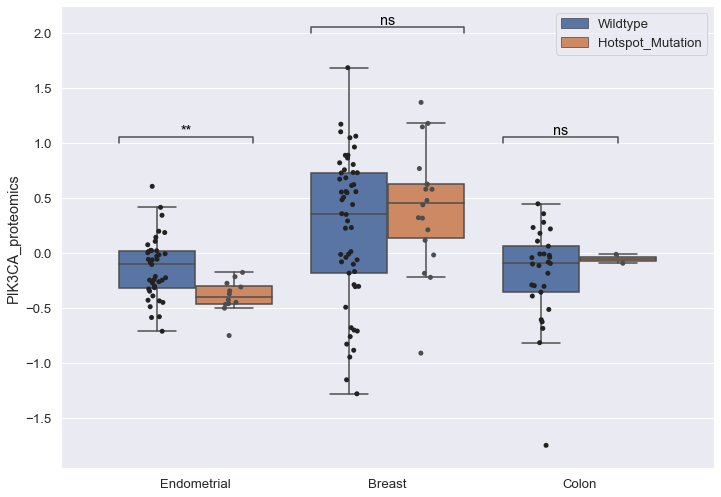

In [15]:
# pancancer cis plot
gene = 'PIK3CA'
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='cancer', y=gene, data = df, hue = 'Mutation',
                      hue_order = ["Wildtype_Tumor", "Missense_Mutation"], showfliers = False)    
boxplot = sns.stripplot(x='cancer', y=gene, data = df, jitter = True, 
                           color = ".3", hue = 'Mutation', hue_order = ["Wildtype_Tumor", "Missense_Mutation"], dodge = True)
boxplot.set(xlabel = "", ylabel = gene+"_proteomics")

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles, ['Wildtype', 'Hotspot_Mutation'])

cancer_list = [ endo_pval, brca_pval, colon_pval]
# create pval annotations
symbols = {}
i = 0
for cancer_df in cancer_list:

    pval = float(cancer_df['P_Value'])
    cancer_names = ["En","Brca","Colon"]
    cancer = cancer_names [i]
    if pval  <= 0.001:
         symbols[cancer] = '***'
    elif pval  <= 0.01:
        symbols[cancer] = '**'  
    elif pval <= 0.05:
        symbols[cancer] = '*'
    else:
        symbols[cancer] = 'ns'
    i += 1
format_pval_annotation(symbols['En'], -.4, 0.3, 1) # Endometrial
format_pval_annotation(symbols['Brca'], .6, 1.4, 2) # Brca
format_pval_annotation(symbols['Colon'], 1.6, 2.2, 1)  # Colon

plt.show()
plt.clf()
plt.close()

In [16]:
fig = boxplot.get_figure()
fig.savefig("PIK3CA_Fig1B.png", dpi = 300)